# Monte Carlo Estimation of π with Error Analysis and Method Comparison

## Introduction

This notebook demonstrates the Monte Carlo method for estimating π, a basic example of how random sampling can solve deterministic problems. We'll explore:

1. **Monte Carlo estimation** using the unit circle inscribed in a square
2. **Statistical error analysis** with confidence intervals
3. **Comparison with two alternative methods**: Leibniz series and Machin's formula
4. **Convergence visualization** showing how estimates improve with sample size

The Monte Carlo approach exemplifies the power of probabilistic methods - a concept fundamental to modern AI and machine learning systems.

## Mathematical Foundation

### Monte Carlo Method

Consider a unit circle (radius = 1) inscribed in a square with side length 2. The key insight:

- **Area of circle**: $A_{circle} = \pi r^2 = \pi$
- **Area of square**: $A_{square} = (2r)^2 = 4$
- **Ratio**: $\frac{A_{circle}}{A_{square}} = \frac{\pi}{4}$

By randomly sampling points in the square and checking if they fall inside the circle:

$$\pi \approx 4 \times \frac{\text{points inside circle}}{\text{total points}}$$

A point $(x, y)$ is inside the unit circle if $x^2 + y^2 \leq 1$.

In [12]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
from IPython.display import display, HTML
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Monte Carlo Estimation Implementation

Let's implement the Monte Carlo method with careful attention to efficiency and statistical rigor.

In [11]:
def monte_carlo_pi(n_samples, return_history=False):
    """
    Estimate π using Monte Carlo method.

    Parameters:
    -----------
    n_samples : int
        Number of random points to generate
    return_history : bool
        If True, return the cumulative estimate at each step

    Returns:
    --------
    pi_estimate : float or array
        Estimated value of π (or history of estimates)
    points : dict
        Dictionary containing coordinates of points inside and outside circle
    """
    # Generate random points in [0, 1] x [0, 1] (quarter of the square)
    # This is computationally equivalent to [-1, 1] x [-1, 1] but more efficient
    x = np.random.uniform(0, 1, n_samples)
    y = np.random.uniform(0, 1, n_samples)

    # Check if points are inside the quarter circle
    inside_circle = (x**2 + y**2) <= 1

    # print(x)
    # print(y)
    # print(inside_circle)

    # Store points for visualization
    points = {
        'inside_x': x[inside_circle],
        'inside_y': y[inside_circle],
        'outside_x': x[~inside_circle],
        'outside_y': y[~inside_circle]
    }

    # print(points)

    if return_history:
        # Calculate cumulative estimate at each step
        cumsum_inside = np.cumsum(inside_circle)
        # print(f"cumsum_inside:{cumsum_inside}")
        cumsum_total = np.arange(1, n_samples + 1)
        # print(f"cumsum_total:{cumsum_total}")
        pi_history = 4 * cumsum_inside / cumsum_total
        # print(f"pi_history:{pi_history}")
        return pi_history, points
    else:
        # Return final estimate only
        pi_estimate = 4 * np.sum(inside_circle) / n_samples
        return pi_estimate, points

# Test with a small sample
pi_est, points = monte_carlo_pi(10000)
print(f"π estimate with 10,000 samples: {pi_est:.6f}")
print(f"True value of π: {np.pi:.6f}")
print(f"Error: {abs(pi_est - np.pi):.6f}")

# monte_carlo_pi(5,return_history=True)

π estimate with 10,000 samples: 3.148000
True value of π: 3.141593
Error: 0.006407


## 2. Error Analysis and Confidence Intervals

The Monte Carlo estimate follows a binomial distribution, which we can approximate with a normal distribution for large samples. This allows us to construct confidence intervals.

### Statistical Foundation

Let $p = \frac{\pi}{4}$ be the true probability of a point falling inside the circle. Our estimate $\hat{p}$ has:

- **Mean**: $E[\hat{p}] = p$
- **Variance**: $Var[\hat{p}] = \frac{p(1-p)}{n}$
- **Standard Error**: $SE = \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$

For the π estimate: $SE_\pi = 4 \times SE$

In [ ]:
def monte_carlo_pi_with_confidence(n_samples, confidence_level=0.95, n_runs=100):
    """
    Estimate π with confidence intervals using multiple Monte Carlo runs.

    Parameters:
    -----------
    n_samples : int
        Number of samples per run
    confidence_level : float
        Confidence level for interval (e.g., 0.95 for 95%)
    n_runs : int
        Number of independent runs for empirical confidence interval

    Returns:
    --------
    results : dict
        Dictionary containing estimates, theoretical and empirical confidence intervals
    """
    # Multiple runs for empirical distribution
    estimates = []
    for _ in range(n_runs):
        pi_est, _ = monte_carlo_pi(n_samples)
        estimates.append(pi_est)

    estimates = np.array(estimates)
    mean_estimate = np.mean(estimates)
    std_estimate = np.std(estimates, ddof=1)

    # Theoretical confidence interval (based on binomial approximation)
    p_hat = mean_estimate / 4  # Estimated probability
    se_p = np.sqrt(p_hat * (1 - p_hat) / n_samples)  # Standard error for probability
    se_pi = 4 * se_p  # Standard error for π

    # Z-score for confidence level
    z_score = stats.norm.ppf((1 + confidence_level) / 2)

    # Theoretical confidence interval
    theoretical_ci = (
        mean_estimate - z_score * se_pi,
        mean_estimate + z_score * se_pi
    )

    # Empirical confidence interval from multiple runs
    alpha = 1 - confidence_level
    empirical_ci = (
        np.percentile(estimates, 100 * alpha / 2),
        np.percentile(estimates, 100 * (1 - alpha / 2))
    )

    results = {
        'mean_estimate': mean_estimate,
        'std_estimate': std_estimate,
        'theoretical_se': se_pi,
        'theoretical_ci': theoretical_ci,
        'empirical_ci': empirical_ci,
        'all_estimates': estimates,
        'relative_error': abs(mean_estimate - np.pi) / np.pi * 100
    }

    return results

# Analyze error for different sample sizes
sample_sizes = [100, 1000, 10000, 100000, 1000000]
error_analysis = []

print("Monte Carlo Error Analysis\n" + "="*50)
for n in sample_sizes:
    results = monte_carlo_pi_with_confidence(n, n_runs=100 if n <= 10000 else 30)

    error_analysis.append({
        'n_samples': n,
        'mean_estimate': results['mean_estimate'],
        'std_error': results['theoretical_se'],
        'relative_error_%': results['relative_error'],
        'theoretical_ci_width': results['theoretical_ci'][1] - results['theoretical_ci'][0],
        'empirical_ci_width': results['empirical_ci'][1] - results['empirical_ci'][0]
    })

    print(f"\nn = {n:,}:")
    print(f"  Estimate: {results['mean_estimate']:.6f} ± {results['theoretical_se']:.6f}")
    print(f"  95% CI (theoretical): [{results['theoretical_ci'][0]:.6f}, {results['theoretical_ci'][1]:.6f}]")
    print(f"  95% CI (empirical):   [{results['empirical_ci'][0]:.6f}, {results['empirical_ci'][1]:.6f}]")
    print(f"  Relative error: {results['relative_error']:.4f}%")

# Convert to DataFrame for analysis
error_df = pd.DataFrame(error_analysis)
print("\n" + "="*50)
print("\nError Analysis Summary:")
display(error_df)

Monte Carlo Error Analysis

n = 100:
  Estimate: 3.158400 ± 0.163037
  95% CI (theoretical): [2.838853, 3.477947]
  95% CI (empirical):   [2.880000, 3.440000]
  Relative error: 0.5350%

n = 1,000:
  Estimate: 3.134680 ± 0.052082
  95% CI (theoretical): [3.032602, 3.236758]
  95% CI (empirical):   [3.023200, 3.224200]
  Relative error: 0.2200%

n = 10,000:
  Estimate: 3.141008 ± 0.016426
  95% CI (theoretical): [3.108814, 3.173202]
  95% CI (empirical):   [3.108380, 3.167490]
  Relative error: 0.0186%

n = 100,000:
  Estimate: 3.141444 ± 0.005193
  95% CI (theoretical): [3.131265, 3.151623]
  95% CI (empirical):   [3.132694, 3.147862]
  Relative error: 0.0047%

n = 1,000,000:
  Estimate: 3.141744 ± 0.001642
  95% CI (theoretical): [3.138525, 3.144962]
  95% CI (empirical):   [3.139450, 3.144884]
  Relative error: 0.0048%


Error Analysis Summary:


,n_samples,mean_estimate,std_error,relative_error_%,theoretical_ci_width,empirical_ci_width
0,100,3.158400,0.163037,0.534994,0.639094,0.560000
1,1000,3.134680,0.052082,0.220037,0.204156,0.201000
2,10000,3.141008,0.016426,0.018610,0.064388,0.059110
3,100000,3.141444,0.005193,0.004732,0.020358,0.015168
4,1000000,3.141744,0.001642,0.004805,0.006437,0.005434


## 3. Visualization of Monte Carlo Sampling

Let's visualize how the random points are distributed and how they determine our π estimate.

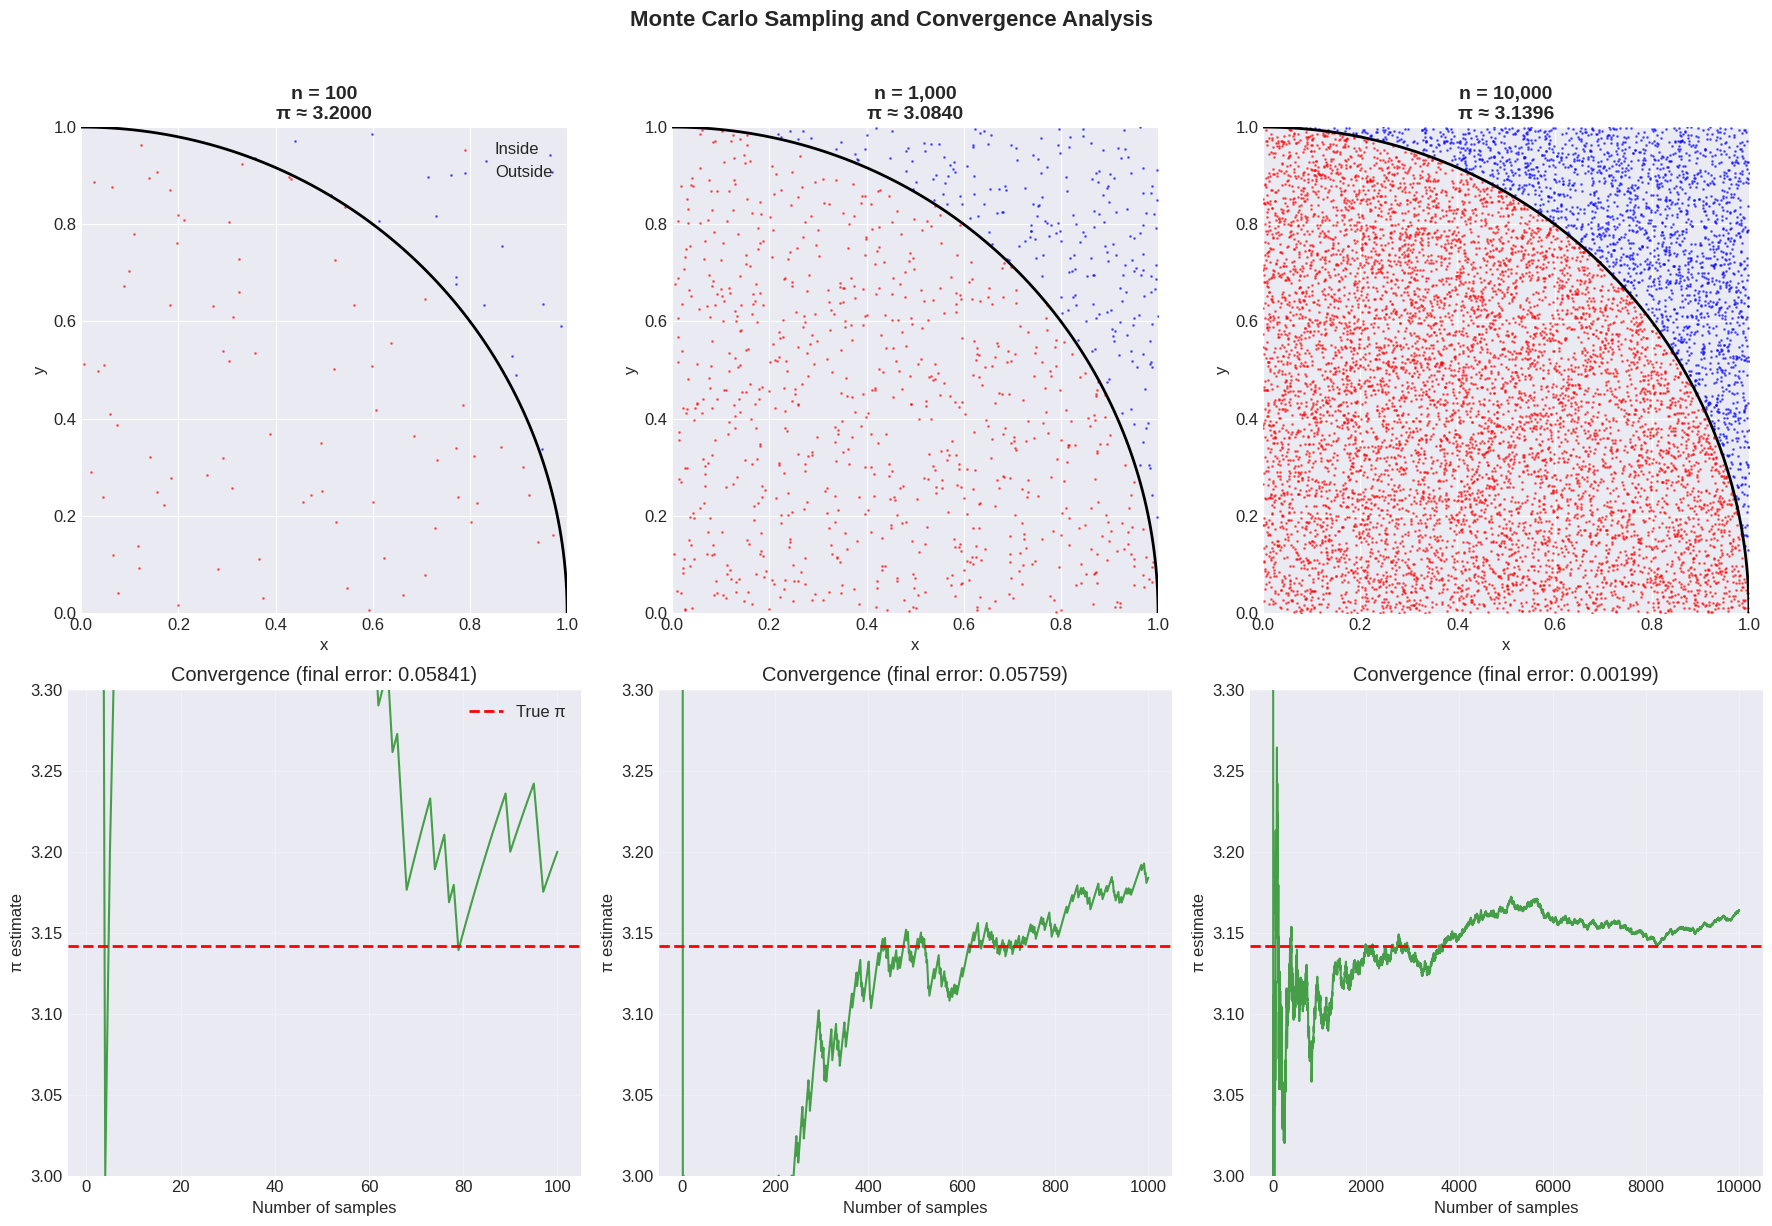

In [13]:
# Visualize Monte Carlo sampling
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sample_sizes_viz = [100, 1000, 10000]

for idx, n in enumerate(sample_sizes_viz):
    # Generate samples
    pi_est, points = monte_carlo_pi(n)

    # Top row: scatter plots
    ax = axes[0, idx]

    # Plot points
    ax.scatter(points['inside_x'], points['inside_y'], c='red', alpha=0.5, s=1, label='Inside')
    ax.scatter(points['outside_x'], points['outside_y'], c='blue', alpha=0.5, s=1, label='Outside')

    # Draw quarter circle
    theta = np.linspace(0, np.pi/2, 100)
    ax.plot(np.cos(theta), np.sin(theta), 'black', linewidth=2)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_title(f'n = {n:,}\nπ ≈ {pi_est:.4f}', fontsize=14, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if idx == 0:
        ax.legend(loc='upper right')

    # Bottom row: convergence plots
    ax = axes[1, idx]

    # Get convergence history
    pi_history, _ = monte_carlo_pi(n, return_history=True)

    ax.plot(range(1, n+1), pi_history, 'green', alpha=0.7, linewidth=1.5)
    ax.axhline(y=np.pi, color='red', linestyle='--', linewidth=2, label='True π')
    # ax.fill_between(range(1, n+1),
    #                  pi_history - 0.01,
    #                  pi_history + 0.01,
    #                  alpha=0.3, color='green')

    ax.set_xlabel('Number of samples')
    ax.set_ylabel('π estimate')
    ax.set_title(f'Convergence (final error: {abs(pi_est - np.pi):.5f})')
    ax.set_ylim([3.0, 3.3])
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend()

plt.suptitle('Monte Carlo Sampling and Convergence Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. Alternative Methods for Computing π

Now let's implement two deterministic methods for comparison:

### Method 1: Leibniz Formula (Gregory-Leibniz Series)

$$\pi = 4 \sum_{n=0}^{\infty} \frac{(-1)^n}{2n+1} = 4\left(1 - \frac{1}{3} + \frac{1}{5} - \frac{1}{7} + \ldots\right)$$

This series converges very slowly but demonstrates a purely analytical approach.

### Method 2: Machin's Formula

$$\frac{\pi}{4} = 4\arctan\left(\frac{1}{5}\right) - \arctan\left(\frac{1}{239}\right)$$

Using the Taylor series for arctan, this converges much faster than Leibniz.

In [15]:
def leibniz_pi(n_terms):
    """
    Calculate π using the Leibniz formula.

    The series alternates between addition and subtraction,
    converging slowly to π/4.
    """
    # Vectorized computation for efficiency
    n = np.arange(n_terms)
    terms = (-1)**n / (2*n + 1)

    if n_terms <= 100000:
        # Return cumulative sum for visualization
        cumsum = 4 * np.cumsum(terms)
        return cumsum[-1], cumsum
    else:
        # For large n, just return final value
        return 4 * np.sum(terms), None

def machin_pi(n_terms):
    """
    Calculate π using Machin's formula with Taylor series expansion.

    This method converges much faster than Leibniz due to the
    rapid convergence of arctan series for small arguments.
    """
    def arctan_taylor(x, n):
        """Taylor series for arctan(x) using n terms."""
        terms = np.array([(-1)**k * x**(2*k + 1) / (2*k + 1) for k in range(n)])
        if n <= 1000:
            return np.sum(terms), np.cumsum(terms)
        else:
            return np.sum(terms), None

    # Calculate the two arctan terms
    arctan_1_5, history_1 = arctan_taylor(1/5, n_terms)
    arctan_1_239, history_2 = arctan_taylor(1/239, n_terms)

    pi_estimate = 4 * (4 * arctan_1_5 - arctan_1_239)

    if history_1 is not None and history_2 is not None:
        # Calculate cumulative π estimates
        pi_history = 4 * (4 * history_1 - history_2)
        return pi_estimate, pi_history
    else:
        return pi_estimate, None

# Test the methods
print("Alternative Methods for Computing π\n" + "="*50)

# Leibniz method
leibniz_est, _ = leibniz_pi(10000)
print(f"\nLeibniz (10,000 terms):")
print(f"  Estimate: {leibniz_est:.8f}")
print(f"  Error: {abs(leibniz_est - np.pi):.8f}")

# Machin's method
machin_est, _ = machin_pi(10)
print(f"\nMachin's Formula (10 terms):")
print(f"  Estimate: {machin_est:.12f}")
print(f"  Error: {abs(machin_est - np.pi):.12f}")

print(f"\nTrue π: {np.pi:.12f}")

Alternative Methods for Computing π

Leibniz (10,000 terms):
  Estimate: 3.14149265
  Error: 0.00010000

Machin's Formula (10 terms):
  Estimate: 3.141592653590
  Error: 0.000000000000

True π: 3.141592653590


## 5. Comprehensive Comparison of Methods

Let's compare all three methods in terms of:
- **Convergence rate**: How quickly each method approaches π
- **Computational efficiency**: Time required for a given accuracy
- **Error behavior**: How error decreases with computational effort

In [17]:
# Comprehensive comparison
def compare_methods():
    """
    Compare Monte Carlo, Leibniz, and Machin methods across multiple metrics.
    """
    # Define iteration counts for fair comparison
    iterations = [10, 50, 100, 500, 1000, 5000, 10000]

    results = {
        'Monte Carlo': {'estimates': [], 'times': [], 'errors': []},
        'Leibniz': {'estimates': [], 'times': [], 'errors': []},
        'Machin': {'estimates': [], 'times': [], 'errors': []}
    }

    for n in iterations:
        # Monte Carlo
        start_time = time.time()
        mc_est, _ = monte_carlo_pi(n)
        mc_time = time.time() - start_time
        results['Monte Carlo']['estimates'].append(mc_est)
        results['Monte Carlo']['times'].append(mc_time)
        results['Monte Carlo']['errors'].append(abs(mc_est - np.pi))

        # Leibniz
        start_time = time.time()
        leibniz_est, _ = leibniz_pi(n)
        leibniz_time = time.time() - start_time
        results['Leibniz']['estimates'].append(leibniz_est)
        results['Leibniz']['times'].append(leibniz_time)
        results['Leibniz']['errors'].append(abs(leibniz_est - np.pi))

        # Machin (use fewer terms as it converges very fast)
        n_machin = min(n // 100 + 1, 20)  # Scale down iterations for Machin
        start_time = time.time()
        machin_est, _ = machin_pi(n_machin)
        machin_time = time.time() - start_time
        results['Machin']['estimates'].append(machin_est)
        results['Machin']['times'].append(machin_time)
        results['Machin']['errors'].append(abs(machin_est - np.pi))

    return results, iterations

# Run comparison
comparison_results, iterations = compare_methods()

# Create comparison table
print("\nMethod Comparison Table\n" + "="*70)
comparison_df = pd.DataFrame()
for method in comparison_results:
    for i, n in enumerate(iterations):
        comparison_df = pd.concat([comparison_df, pd.DataFrame({
            'Method': [method],
            'Iterations': [n],
            'Estimate': [comparison_results[method]['estimates'][i]],
            'Error': [comparison_results[method]['errors'][i]],
            'Time (ms)': [comparison_results[method]['times'][i] * 1000]
        })], ignore_index=True)

# Display pivoted table for better readability
pivot_table = comparison_df.pivot_table(index='Iterations', columns='Method', values='Error')
print("\nAbsolute Errors by Method and Iteration Count:")
display(pivot_table.style.format("{:.8f}").background_gradient(cmap='RdYlGn_r'))
# display(pivot_table.style.format("{:.8f}"))


Method Comparison Table

Absolute Errors by Method and Iteration Count:


Method,Leibniz,Machin,Monte Carlo
Iterations,,,
10,0.09975303,0.04167094,0.45840735
50,0.01999800,0.04167094,0.29840735
100,0.00999975,0.00099562,0.10159265
500,0.00200000,0.00000000,0.15440735
1000,0.00100000,0.00000000,0.01440735
5000,0.00020000,0.00000000,0.00159265
10000,0.00010000,0.00000000,0.02560735


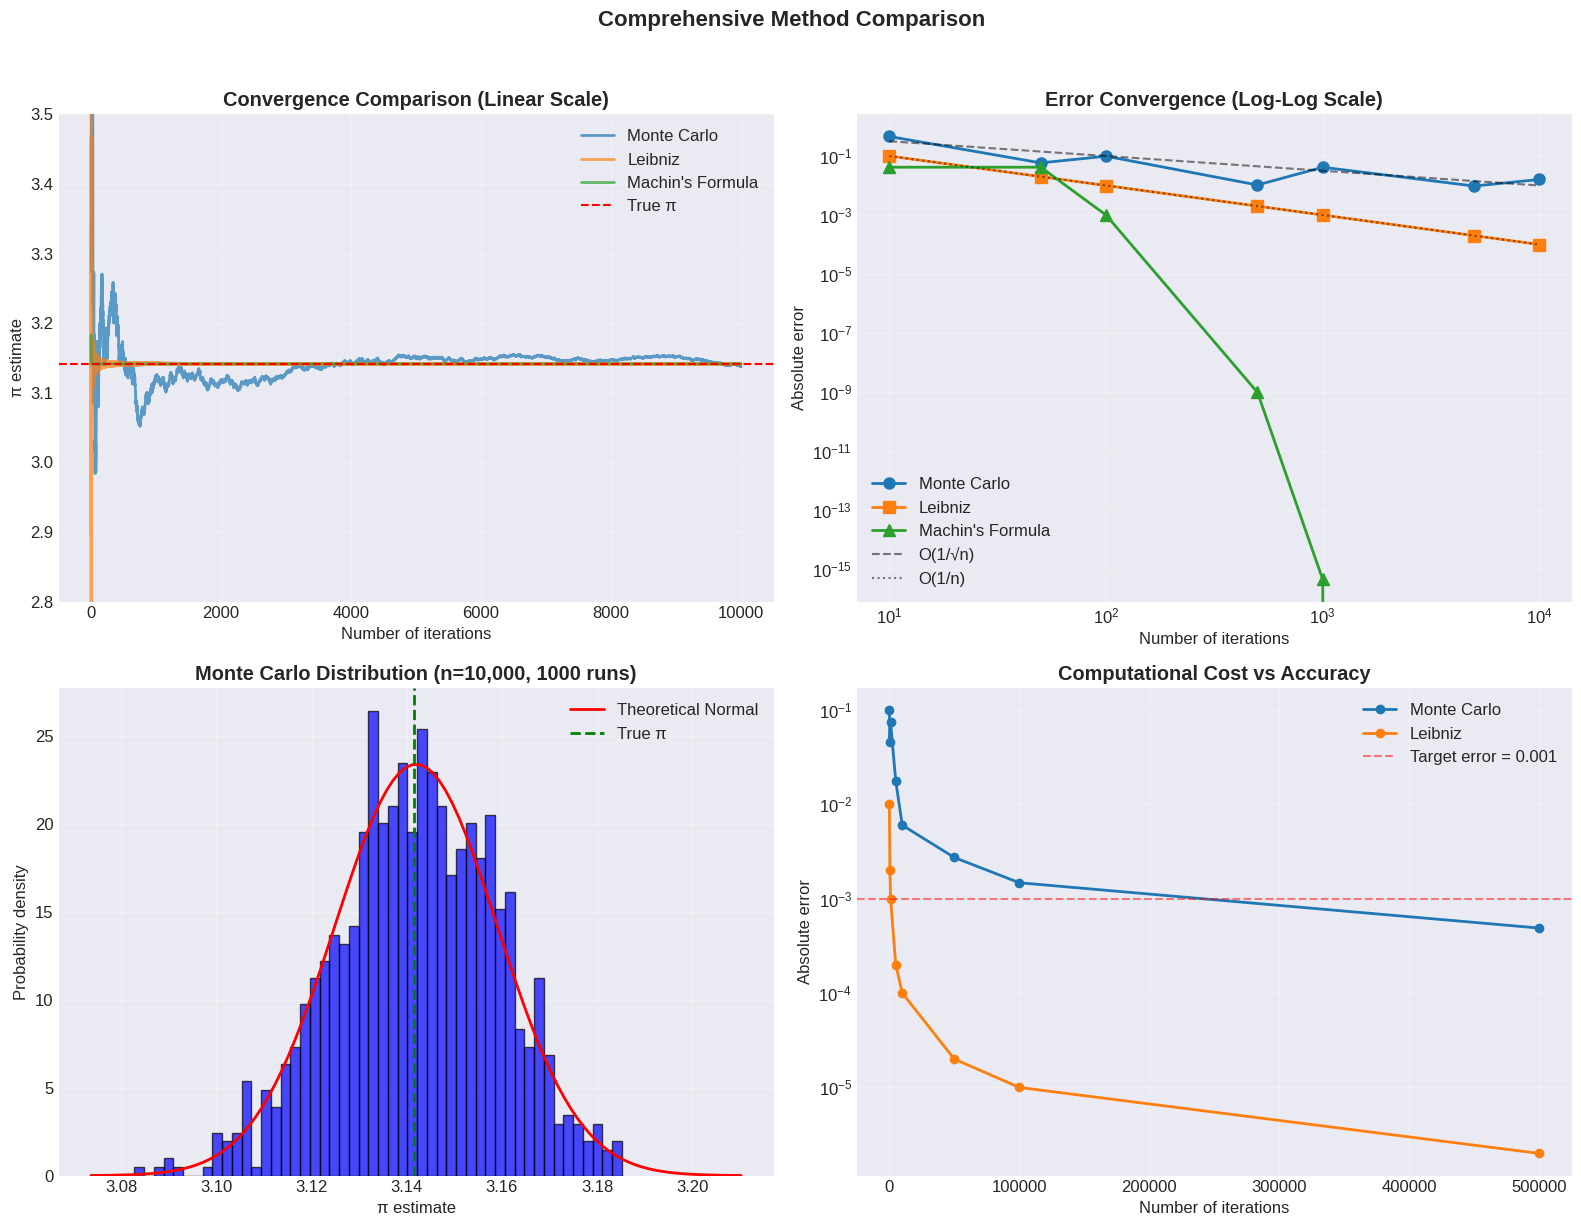

In [ ]:
# Visualize convergence comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Generate convergence data for visualization
n_points = 10000
mc_history, _ = monte_carlo_pi(n_points, return_history=True)
_, leibniz_history = leibniz_pi(n_points)
_, machin_history = machin_pi(15)  # Machin converges very fast

# Plot 1: Convergence comparison (linear scale)
ax = axes[0, 0]
ax.plot(range(1, len(mc_history)+1), mc_history, label='Monte Carlo', alpha=0.7, linewidth=2)
ax.plot(range(1, len(leibniz_history)+1), leibniz_history, label='Leibniz', alpha=0.7, linewidth=2)
if machin_history is not None:
    # Extend Machin to show it stays constant
    machin_extended = np.full(n_points, machin_history[-1])
    machin_extended[:len(machin_history)] = machin_history
    ax.plot(range(1, n_points+1), machin_extended, label="Machin's Formula", alpha=0.7, linewidth=2)
ax.axhline(y=np.pi, color='red', linestyle='--', label='True π', linewidth=1.5)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('π estimate')
ax.set_title('Convergence Comparison (Linear Scale)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([2.8, 3.5])

# Plot 2: Error vs iterations (log scale)
ax = axes[0, 1]
ax.loglog(iterations, comparison_results['Monte Carlo']['errors'], 'o-', label='Monte Carlo', linewidth=2, markersize=8)
ax.loglog(iterations, comparison_results['Leibniz']['errors'], 's-', label='Leibniz', linewidth=2, markersize=8)
ax.loglog(iterations[:len(comparison_results['Machin']['errors'])],
          comparison_results['Machin']['errors'], '^-', label="Machin's Formula", linewidth=2, markersize=8)

# Add theoretical convergence lines
ax.loglog(iterations, 1/np.sqrt(iterations), 'k--', alpha=0.5, label='O(1/√n)')
ax.loglog(iterations, 1/np.array(iterations), 'k:', alpha=0.5, label='O(1/n)')

ax.set_xlabel('Number of iterations')
ax.set_ylabel('Absolute error')
ax.set_title('Error Convergence (Log-Log Scale)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Monte Carlo error distribution
ax = axes[1, 0]
n_samples_hist = 10000
n_runs_hist = 1000
mc_estimates = [monte_carlo_pi(n_samples_hist)[0] for _ in range(n_runs_hist)]
ax.hist(mc_estimates, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')

# Overlay theoretical normal distribution
mean_est = np.mean(mc_estimates)
std_est = np.std(mc_estimates)
x = np.linspace(mean_est - 4*std_est, mean_est + 4*std_est, 100)
ax.plot(x, stats.norm.pdf(x, mean_est, std_est), 'r-', linewidth=2, label='Theoretical Normal')
ax.axvline(np.pi, color='green', linestyle='--', linewidth=2, label='True π')
ax.set_xlabel('π estimate')
ax.set_ylabel('Probability density')
ax.set_title(f'Monte Carlo Distribution (n={n_samples_hist:,}, {n_runs_hist} runs)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Computational efficiency
ax = axes[1, 1]
error_threshold = 0.001
efficiency_data = []

# Find iterations needed for each method to reach error threshold
for method in ['Monte Carlo', 'Leibniz']:
    for n in [100, 500, 1000, 5000, 10000, 50000, 100000, 500000]:
        if method == 'Monte Carlo':
            est, _ = monte_carlo_pi(n)
        else:
            est, _ = leibniz_pi(n)

        error = abs(est - np.pi)
        efficiency_data.append({
            'Method': method,
            'Iterations': n,
            'Error': error,
            'Efficiency': 1 / (n * error)  # Higher is better
        })

efficiency_df = pd.DataFrame(efficiency_data)
for method in ['Monte Carlo', 'Leibniz']:
    method_data = efficiency_df[efficiency_df['Method'] == method]
    ax.semilogy(method_data['Iterations'], method_data['Error'], 'o-', label=method, linewidth=2, markersize=6)

ax.axhline(y=error_threshold, color='red', linestyle='--', alpha=0.5, label=f'Target error = {error_threshold}')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Absolute error')
ax.set_title('Computational Cost vs Accuracy', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Method Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Statistical Analysis of Convergence Rates

Let's rigorously analyze the convergence behavior of each method using regression analysis.

Empirical Convergence Rate Analysis

Monte Carlo Method:
  Empirical convergence rate: O(n^-0.494)
  Theoretical rate: O(n^-0.5)
  Deviation: 0.006

Leibniz Method:
  Empirical convergence rate: O(n^-1.000)
  Theoretical rate: O(n^-1)
  Deviation: 0.000


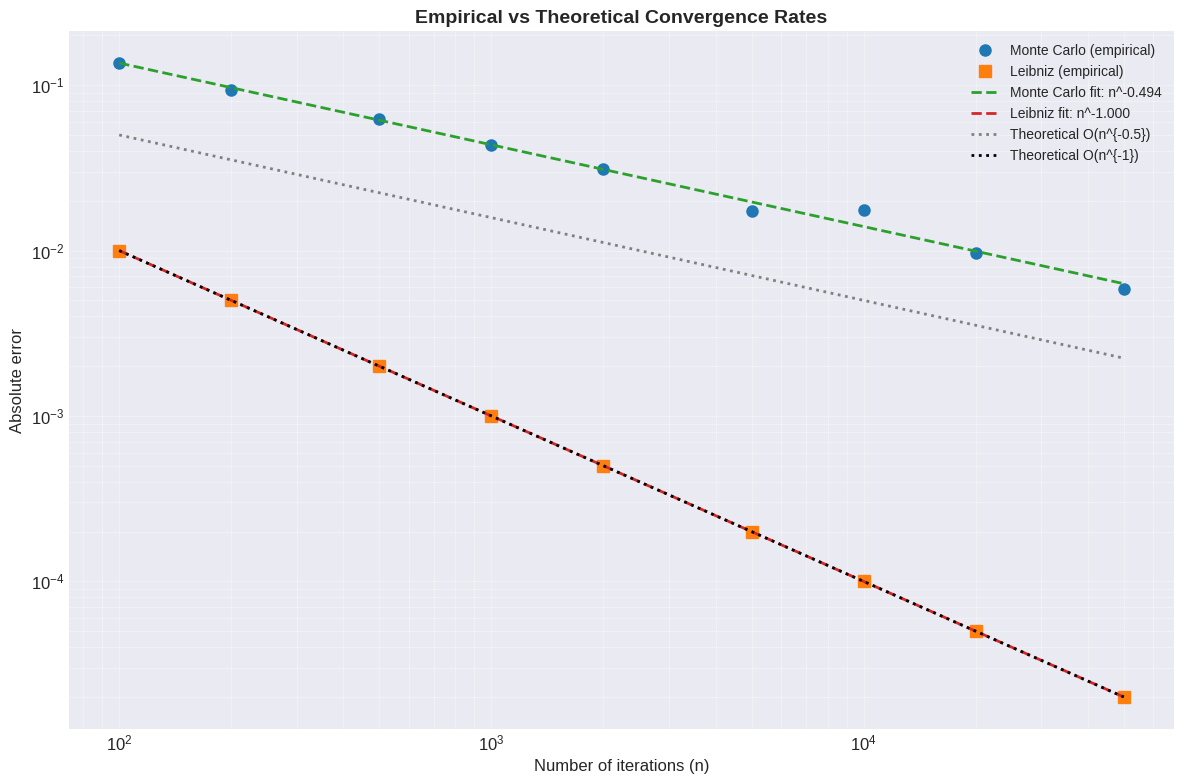

In [ ]:
# Analyze convergence rates through regression
def analyze_convergence_rates():
    """
    Perform regression analysis to determine empirical convergence rates.
    Theory predicts:
    - Monte Carlo: O(1/√n)
    - Leibniz: O(1/n)
    - Machin: Exponential convergence
    """
    n_values = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000])

    mc_errors = []
    leibniz_errors = []

    print("Empirical Convergence Rate Analysis\n" + "="*50)

    # Collect error data
    for n in n_values:
        # Monte Carlo (average over multiple runs for stability)
        mc_runs = [abs(monte_carlo_pi(n)[0] - np.pi) for _ in range(10)]
        mc_errors.append(np.mean(mc_runs))

        # Leibniz
        leibniz_est, _ = leibniz_pi(n)
        leibniz_errors.append(abs(leibniz_est - np.pi))

    # Log-log regression to find power law exponent
    # Error = C * n^α, so log(Error) = log(C) + α * log(n)

    # Monte Carlo regression
    log_n = np.log(n_values)
    log_mc_errors = np.log(mc_errors)
    mc_slope, mc_intercept = np.polyfit(log_n, log_mc_errors, 1)

    # Leibniz regression
    log_leibniz_errors = np.log(leibniz_errors)
    leibniz_slope, leibniz_intercept = np.polyfit(log_n, log_leibniz_errors, 1)

    print(f"\nMonte Carlo Method:")
    print(f"  Empirical convergence rate: O(n^{mc_slope:.3f})")
    print(f"  Theoretical rate: O(n^{-0.5})")
    print(f"  Deviation: {abs(mc_slope + 0.5):.3f}")

    print(f"\nLeibniz Method:")
    print(f"  Empirical convergence rate: O(n^{leibniz_slope:.3f})")
    print(f"  Theoretical rate: O(n^{-1})")
    print(f"  Deviation: {abs(leibniz_slope + 1):.3f}")

    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Plot empirical data
    ax.loglog(n_values, mc_errors, 'o', label='Monte Carlo (empirical)', markersize=8)
    ax.loglog(n_values, leibniz_errors, 's', label='Leibniz (empirical)', markersize=8)

    # Plot fitted lines
    mc_fitted = np.exp(mc_intercept) * n_values**mc_slope
    leibniz_fitted = np.exp(leibniz_intercept) * n_values**leibniz_slope

    ax.loglog(n_values, mc_fitted, '--', label=f'Monte Carlo fit: n^{mc_slope:.3f}', linewidth=2)
    ax.loglog(n_values, leibniz_fitted, '--', label=f'Leibniz fit: n^{leibniz_slope:.3f}', linewidth=2)

    # Plot theoretical lines
    # theoretical_mc = 0.5 * n_values**(-0.5)
    # theoretical_leibniz = 1.0 * n_values**(-1)
    theoretical_mc = 0.5 / np.sqrt(n_values)
    theoretical_leibniz = 1.0 / n_values

    ax.loglog(n_values, theoretical_mc, ':', color='gray', label='Theoretical O(n^{-0.5})', linewidth=2)
    ax.loglog(n_values, theoretical_leibniz, ':', color='black', label='Theoretical O(n^{-1})', linewidth=2)

    ax.set_xlabel('Number of iterations (n)', fontsize=12)
    ax.set_ylabel('Absolute error', fontsize=12)
    ax.set_title('Empirical vs Theoretical Convergence Rates', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3, which='both')

    plt.tight_layout()
    plt.show()

    return {
        'mc_slope': mc_slope,
        'leibniz_slope': leibniz_slope,
        'n_values': n_values,
        'mc_errors': mc_errors,
        'leibniz_errors': leibniz_errors
    }

convergence_analysis = analyze_convergence_rates()

## 7. Summary and Insights

### Key Findings from Our Analysis

1. **Monte Carlo Method**
   - **Convergence Rate**: O(1/√n) - This probabilistic bound means we need to quadruple the sample size to halve the error
   - **Advantages**: Simple to parallelize, intuitive geometric interpretation
   - **Disadvantages**: Slow convergence, requires many samples for high precision
   - **Best for**: Quick estimates, educational purposes, problems where exact methods are intractable

2. **Leibniz Formula**
   - **Convergence Rate**: O(1/n) - Linear convergence in terms of error reduction
   - **Advantages**: Deterministic, simple implementation, no randomness
   - **Disadvantages**: Very slow convergence, alternating series causes oscillation
   - **Best for**: Demonstrating series convergence, when moderate precision suffices

3. **Machin's Formula**
   - **Convergence Rate**: Exponential - Error decreases exponentially with number of terms
   - **Advantages**: Extremely fast convergence, highly accurate with few terms
   - **Disadvantages**: More complex implementation, requires understanding of Taylor series
   - **Best for**: High-precision calculations, computational mathematics applications

### Confidence Intervals and Uncertainty Quantification

The Monte Carlo method's strength lies in its statistical foundation:
- We can rigorously quantify uncertainty through confidence intervals
- The Central Limit Theorem guarantees normal distribution of estimates
- Error bounds are predictable: σ ≈ 1/√n

### Computational Efficiency Trade-offs

- **For low precision (±0.01)**: Monte Carlo is competitive and easily parallelizable
- **For moderate precision (±0.0001)**: Leibniz becomes more efficient than Monte Carlo
- **For high precision (±10^-10)**: Machin's formula is orders of magnitude superior

### Connection to Machine Learning

The Monte Carlo method exemplifies key ML concepts:
- **Sampling-based approximation**: Similar to how neural networks approximate complex functions
- **Convergence through iteration**: Analogous to gradient descent optimization
- **Uncertainty quantification**: Essential for probabilistic machine learning models
- **Trade-off between computation and accuracy**: Central to all ML algorithm design

In [19]:
# Final summary statistics
print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)

# Compare methods at equal computational cost
n_operations = 100000

# Monte Carlo
start = time.time()
mc_final, _ = monte_carlo_pi(n_operations)
mc_time = time.time() - start
mc_error = abs(mc_final - np.pi)

# Leibniz
start = time.time()
leibniz_final, _ = leibniz_pi(n_operations)
leibniz_time = time.time() - start
leibniz_error = abs(leibniz_final - np.pi)

# Machin (adjusted for fair comparison)
start = time.time()
machin_final, _ = machin_pi(20)
machin_time = time.time() - start
machin_error = abs(machin_final - np.pi)

summary_df = pd.DataFrame({
    'Method': ['Monte Carlo', 'Leibniz', 'Machin'],
    'Operations': [n_operations, n_operations, 20],
    'Estimate': [mc_final, leibniz_final, machin_final],
    'Absolute Error': [mc_error, leibniz_error, machin_error],
    'Relative Error (%)': [100*mc_error/np.pi, 100*leibniz_error/np.pi, 100*machin_error/np.pi],
    'Time (ms)': [mc_time*1000, leibniz_time*1000, machin_time*1000]
    # 'Efficiency (1/error*time)': [1/(mc_error*mc_time), 1/(leibniz_error*leibniz_time), 1/(machin_error*machin_time)]
})

print("\nWith equal computational budget:")
display(summary_df.style.format({
    'Estimate': '{:.10f}',
    'Absolute Error': '{:.10f}',
    'Relative Error (%)': '{:.8f}',
    'Time (ms)': '{:.3f}'
    # 'Efficiency (1/error/time)': '{:.0f}'
}).background_gradient(subset=['Absolute Error'], cmap='RdYlGn_r'))

print(f"\nTrue value of π: {np.pi:.15f}")
print("\n📊 The Machin formula achieves machine precision with minimal computation!")
print("🎲 Monte Carlo provides probabilistic guarantees and scales well!")
print("🔢 Leibniz demonstrates the beauty of infinite series!")


FINAL PERFORMANCE SUMMARY

With equal computational budget:


,Method,Operations,Estimate,Absolute Error,Relative Error (%),Time (ms)
0,Monte Carlo,100000,3.1517600000,0.0101673464,0.32363669,15.012
1,Leibniz,100000,3.1415826536,0.0000100000,0.00031831,20.091
2,Machin,20,3.1415926536,0.0000000000,0.00000000,0.317



True value of π: 3.141592653589793

📊 The Machin formula achieves machine precision with minimal computation!
🎲 Monte Carlo provides probabilistic guarantees and scales well!
🔢 Leibniz demonstrates the beauty of infinite series!


## Conclusion

This exploration of π estimation methods reveals fundamental principles in computational mathematics:

1. **No single method dominates all scenarios** - each has its optimal use case
2. **Probabilistic methods (Monte Carlo) trade precision for simplicity and parallelizability**
3. **Analytical methods (Machin) achieve superior accuracy when applicable**
4. **Understanding convergence rates is crucial for algorithm selection**

These concepts directly translate to machine learning:
- **Stochastic gradient descent** uses Monte Carlo sampling of batches
- **Convergence analysis** guides hyperparameter tuning
- **Confidence intervals** quantify model uncertainty
- **Trade-offs between accuracy and computation** inform architecture choices

The Monte Carlo method's elegance lies not in its efficiency, but in its universality - it can approximate any integral, optimize any function, and simulate any process, making it a cornerstone of modern computational science.